# Import Libraries

In [1]:
globals().clear
import time
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import xgboost as xgb

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'sklearn'

# Load dataset and filter

In [ ]:
# Load Dataset
def loadDataset():
    return pd.read_csv('df.csv')

In [ ]:
# For this specific trial, filter the dataframe
def filterDataset(tickers, df):
    df[df.stock_ID.isin(tickers)]

In [8]:
# Reindexing
# newCols = ['stock_ID', 'Close', 'Volume_PP', 'DATETIME']
# df = df[[nCol for nCol in newCols] + [col for col in df.columns if col not in newCols]]
# df

,stock_ID,Close,Volume_PP,DATETIME,P/E Ratio ttm,P/B Ratio mrq,D/E Ratio mrq,Free Cash Flow ttm,pegRatio,ROE ttm,...,DAY_22,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30,DAY_31
2470,AAPL,49.95,104270048,2019-06-26,33.245342,44.262974,140.968,8.472687e+10,3.08,1.47250,...,0,0,0,0,1,0,0,0,0,0
2471,AAPL,49.94,83598868,2019-06-27,33.245342,44.262974,140.968,8.472687e+10,3.08,1.47250,...,0,0,0,0,0,1,0,0,0,0
2472,AAPL,49.48,124442568,2019-06-28,33.245342,44.262974,140.968,8.472687e+10,3.08,1.47250,...,0,0,0,0,0,0,1,0,0,0
2473,AAPL,50.39,109266956,2019-07-01,33.245342,44.262974,140.968,8.472687e+10,3.08,1.47250,...,0,0,0,0,0,0,0,0,0,0
2474,AAPL,50.68,67740868,2019-07-02,33.245342,44.262974,140.968,8.472687e+10,3.08,1.47250,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608468,XOM,111.51,11319743,2024-06-21,14.080883,2.207323,18.981,2.643587e+10,1.88,0.16248,...,0,0,0,0,0,0,0,0,0,0
608469,XOM,114.21,7897051,2024-06-24,14.080883,2.207323,18.981,2.643587e+10,1.88,0.16248,...,0,0,1,0,0,0,0,0,0,0
608470,XOM,113.97,6726291,2024-06-25,14.080883,2.207323,18.981,2.643587e+10,1.88,0.16248,...,0,0,0,1,0,0,0,0,0,0
608471,XOM,114.70,7526301,2024-06-26,14.080883,2.207323,18.981,2.643587e+10,1.88,0.16248,...,0,0,0,0,1,0,0,0,0,0


In [9]:
# # df['DATETIME']= pd.to_datetime(df['DATETIME'], format='%m/%d/%Y %H:%M')
# df['DATETIME']= pd.to_datetime(df['DATETIME'], format ='%Y-%m-%d')

In [10]:
# # Sort by time so that the first 29 rows occupy the first time value for all the stocks.
# # Fill in 0's for missing values for now.
# df = df.set_index('DATETIME')
# df = df.fillna(0)

In [11]:
# # Select the length of the df: should include start of training window and end of prediction date
# df = df.sort_index().loc['2019-06-26':'2024-06-15']

In [12]:
# #Set the DATETIME for fecha
# DATETIME = df.index.values

In [13]:
# # Sort dataframe such that it is both in sequential order, and also in alphabetical order for each day
# #(i.e first entry for each time entry should be AAPL, and last should be XOM).
# df.sort_values(["DATETIME", "stock_ID"], inplace=True)

In [ ]:
def preprocess(df):
    # Reindexing
    newCols = ['stock_ID', 'Close', 'Volume_PP', 'DATETIME']
    df = df[[nCol for nCol in newCols] + [col for col in df.columns if col not in newCols]]
    # Convert format to datetime
    df['DATETIME']= pd.to_datetime(df['DATETIME'], format ='%Y-%m-%d')
    # Sort by time so that the first rows occupy the first time value for all the stocks.
    # Fill in 0's for missing values for now.
    df = df.set_index('DATETIME')
    df = df.fillna(0)
    # Select the length of the df: should include start of training window and end of prediction date
    df = df.sort_index().loc['2019-06-26':'2024-06-15']#
    #Set the DATETIME for fecha
    DATETIME = df.index.values
    # Sort dataframe such that it is both in sequential order, and also in alphabetical order for each day
    df.sort_values(["DATETIME", "stock_ID"], inplace=True)
    return [df, DATETIME]

# Train model and generate prediction

In [ ]:
# file_name = 'XGB.60d.1d'
def trainModel(trainingDateStart,predictionDateStart, predictionDateEnd, daysToPredict):
    num_companies = 28
    step_rows  = num_companies * daysToPredict # Multiply by number of days to predict
    total_rows = len(df[trainingDateStart:predictionDateEnd])  # Define total length to predict on
    train_rows = len(df[trainingDateStart:predictionDateStart])  # Define length of training window
    
    scale_X = MinMaxScaler()
    model = XGBRegressor(n_estimators=300, max_depth=100, learning_rate=0.1, objective='reg:squarederror'
                         , alpha=10, tree_method="hist", device="cuda")
    
    result = pd.DataFrame(columns=['DATETIME', 'ACTUAL', 'PREDICTED', 'DIFFERENCE', 'TRAIN_DURATION'])
    
    for i in range(0, total_rows - train_rows, step_rows):
        st = time.time()
        # 1. Obtain X and y
        train  = df.iloc[i:train_rows + i, 1:]
        test   = df.iloc[train_rows + i:train_rows + i + step_rows, 1:]
        X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
        X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
    
    
        # 2. Scale X
        X_train = scale_X.fit_transform(X_train)
        X_test = scale_X.transform(X_test)
    
        # 3. Fit and Predict
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        et = time.time()
    
        # 4. Save data with prediction
        fecha = DATETIME[train_rows + i:train_rows + i + step_rows]
        stockID = df['stock_ID'][train_rows + i:train_rows + i + step_rows]
        datos = {
            'stock_ID' : stockID,
            'DATETIME': fecha,
            'ACTUAL': y_test,
            'PREDICTED': y_hat,
            'DIFFERENCE': abs(y_hat - y_test),
            'TRAIN_DURATION': np.full(y_hat.shape[0], et - st)
        }
        data = pd.DataFrame(data=datos)
        result = pd.concat([result, data], ignore_index=True)
    
        print("Count Down:", int((total_rows - train_rows - i) / step_rows))
    return result

# Result Analysis

In [16]:
# result[0::num_companies]
# result.DATETIME.value_counts()
# result['DATETIME'] = pd.to_datetime(result['DATETIME'])

In [ ]:
def plotPrediction(result):
    stock_ids = result['stock_ID'].unique()
    sns.set(style='ticks')
    fig, axes = plt.subplots(len(stock_ids), 1, figsize=(20, 5 * len(stock_ids)))
    fig.subplots_adjust(hspace=0.5)
    
    for i, stock in enumerate(stock_ids):
        data = result[result['stock_ID'] == stock]
        sns.lineplot(ax=axes[i], data=data,x='DATETIME',y='ACTUAL',linewidth=1, label='Actual price', color='red')
        sns.lineplot(ax=axes[i], data=data,x='DATETIME',y='PREDICTED',linewidth=1, label='Predicted price', color='darkblue')
        axes[i].set_title(f'Stock {stock}')
        axes[i].set_ylabel('Price (USD)')
        axes[i].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()

# Metrics Analysis

In [19]:
def calculateMetrics(result):
    # Create Dataframe for the results
    metrics_df = pd.DataFrame(columns = ['stock_ID', "RMSE", "MAPE", "MPE", "MTT"])
    def mean_positive_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        error = np.mean(np.maximum((y_pred - y_true),0))
        return error
    
    new_rows = []
    for i in range(len(tickers)):
        stock_result = result[i::num_companies]
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(stock_result['ACTUAL'], stock_result['PREDICTED']))
        # Calculate MAPE %
        mape = mean_absolute_percentage_error(stock_result['ACTUAL'], stock_result['PREDICTED']) * 100
        # Calculate MPE %
        mpe = mean_positive_error(stock_result['ACTUAL'],stock_result['PREDICTED'])
        # Calculate MTT in seconds
        mtt = np.mean(stock_result['TRAIN_DURATION'])
        new_row = pd.Series([tickers[i],rmse, mape, mpe, mtt], index=metrics_df.columns)
        new_rows.append(new_row)
    metrics_df = pd.DataFrame(new_rows)
    return metrics_df

In [21]:

# metrics_df

,RMSE,MAPE,MPE,MTT
stock_ID,,,,
AAPL,5.616180,2.279171,1.339479,7.871564
AMD,9.508164,4.235866,2.762222,7.871564
AMZN,5.245516,2.182583,0.667749,7.871564
BA,8.170796,3.288400,4.958522,7.871564
BAC,1.160225,2.573943,0.193977,7.871564
C,1.603727,2.093399,0.275568,7.871564
CSCO,5.995137,4.364180,2.012745,7.871564
CVX,3.701441,1.883389,0.798275,7.871564
DIS,5.865399,4.148921,2.738099,7.871564


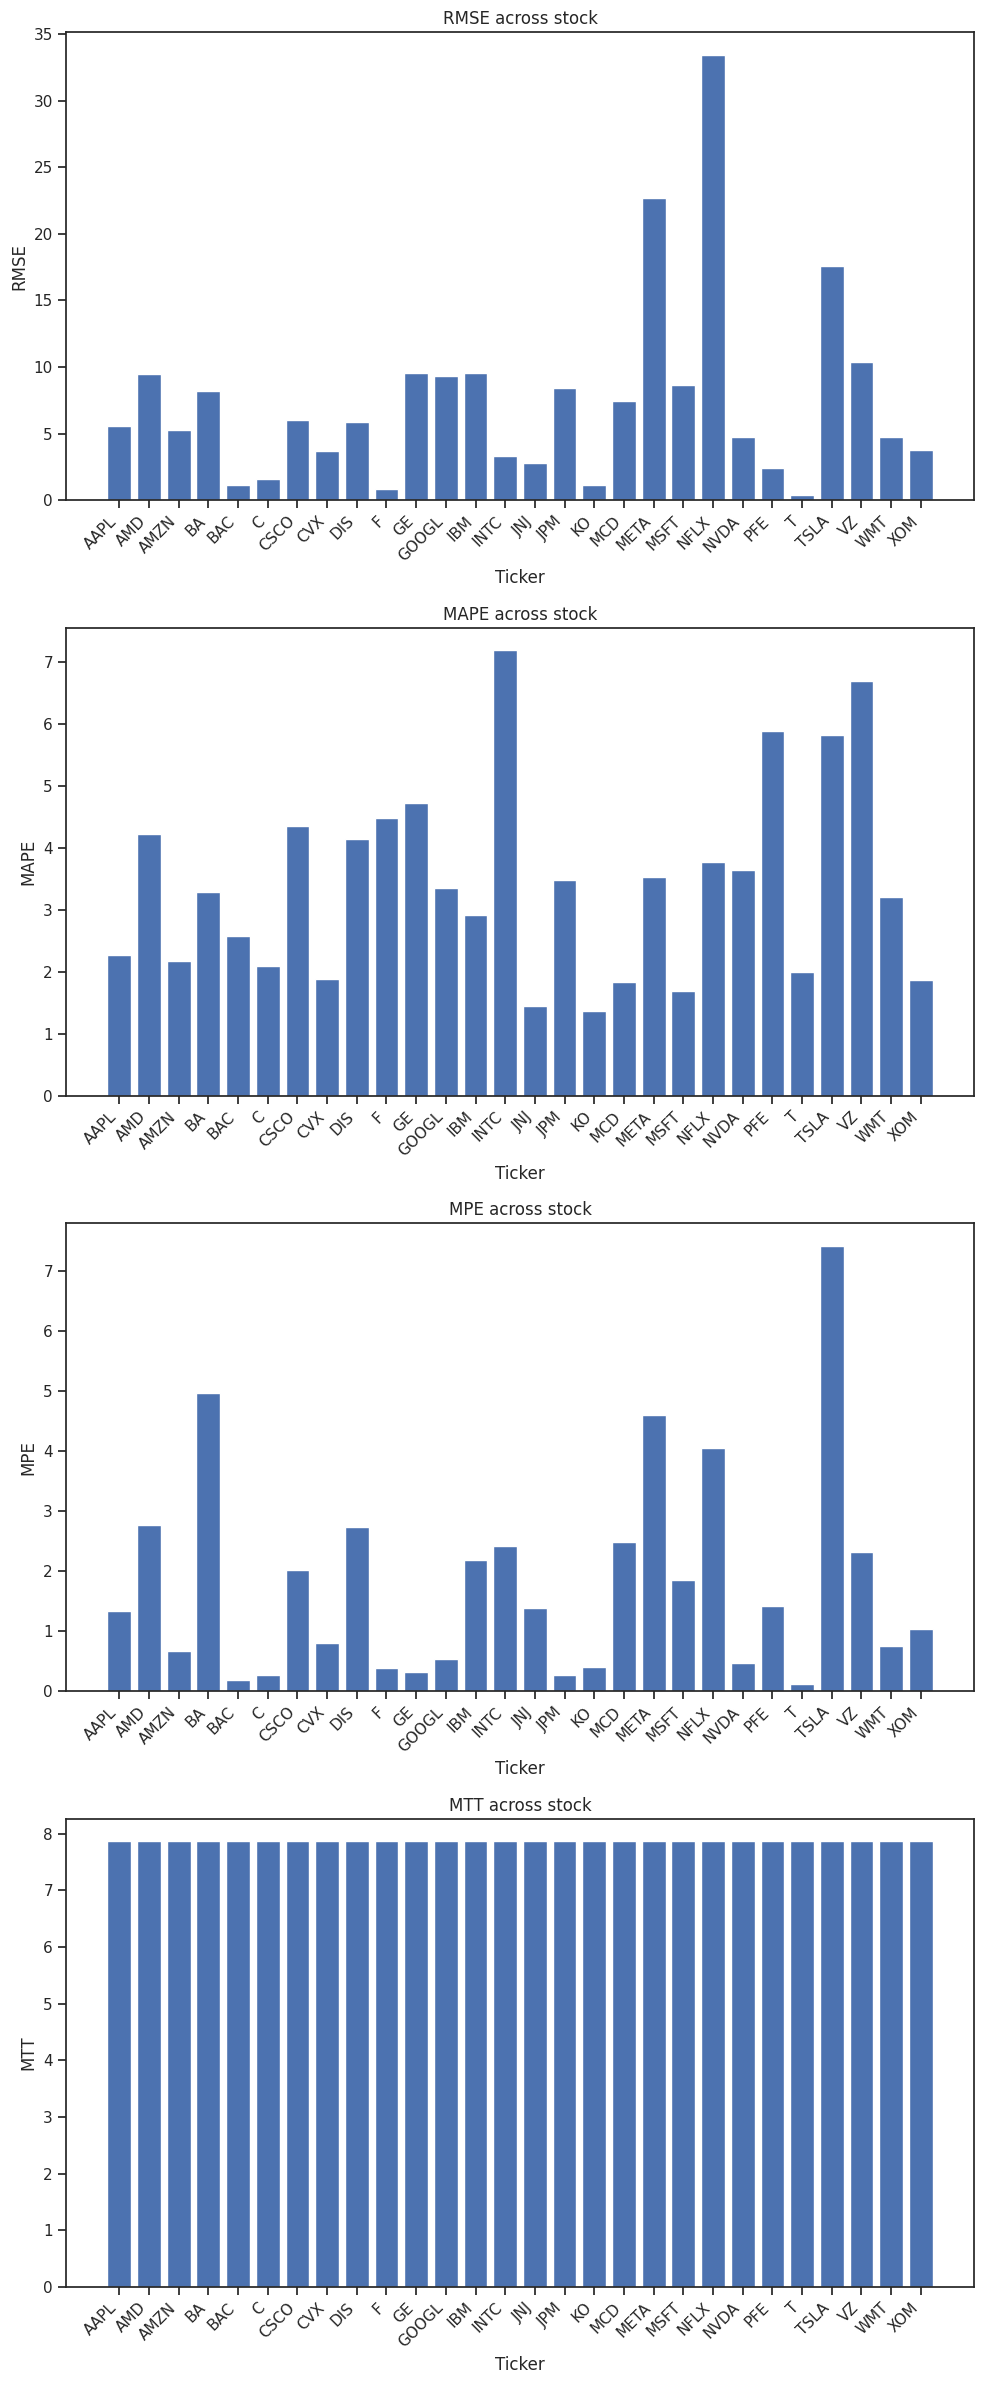

In [25]:
def plotMetrics(metrics_df):
    metrics = ["RMSE", "MAPE", "MPE", "MTT"]
    metrics_df.set_index('stock_ID',inplace=True)
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 6 * len(metrics)))
    fig.subplots_adjust(hspace=0.5)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.bar(metrics_df.index, metrics_df[metric])
        ax.set_title(f'{metric} across stock')
        ax.set_ylabel(metric)
        ax.set_xlabel('Ticker')
        ax.set_xticks(range(len(metrics_df.index)))
        ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
        
    plt.tight_layout()
    plt.show()